<center>

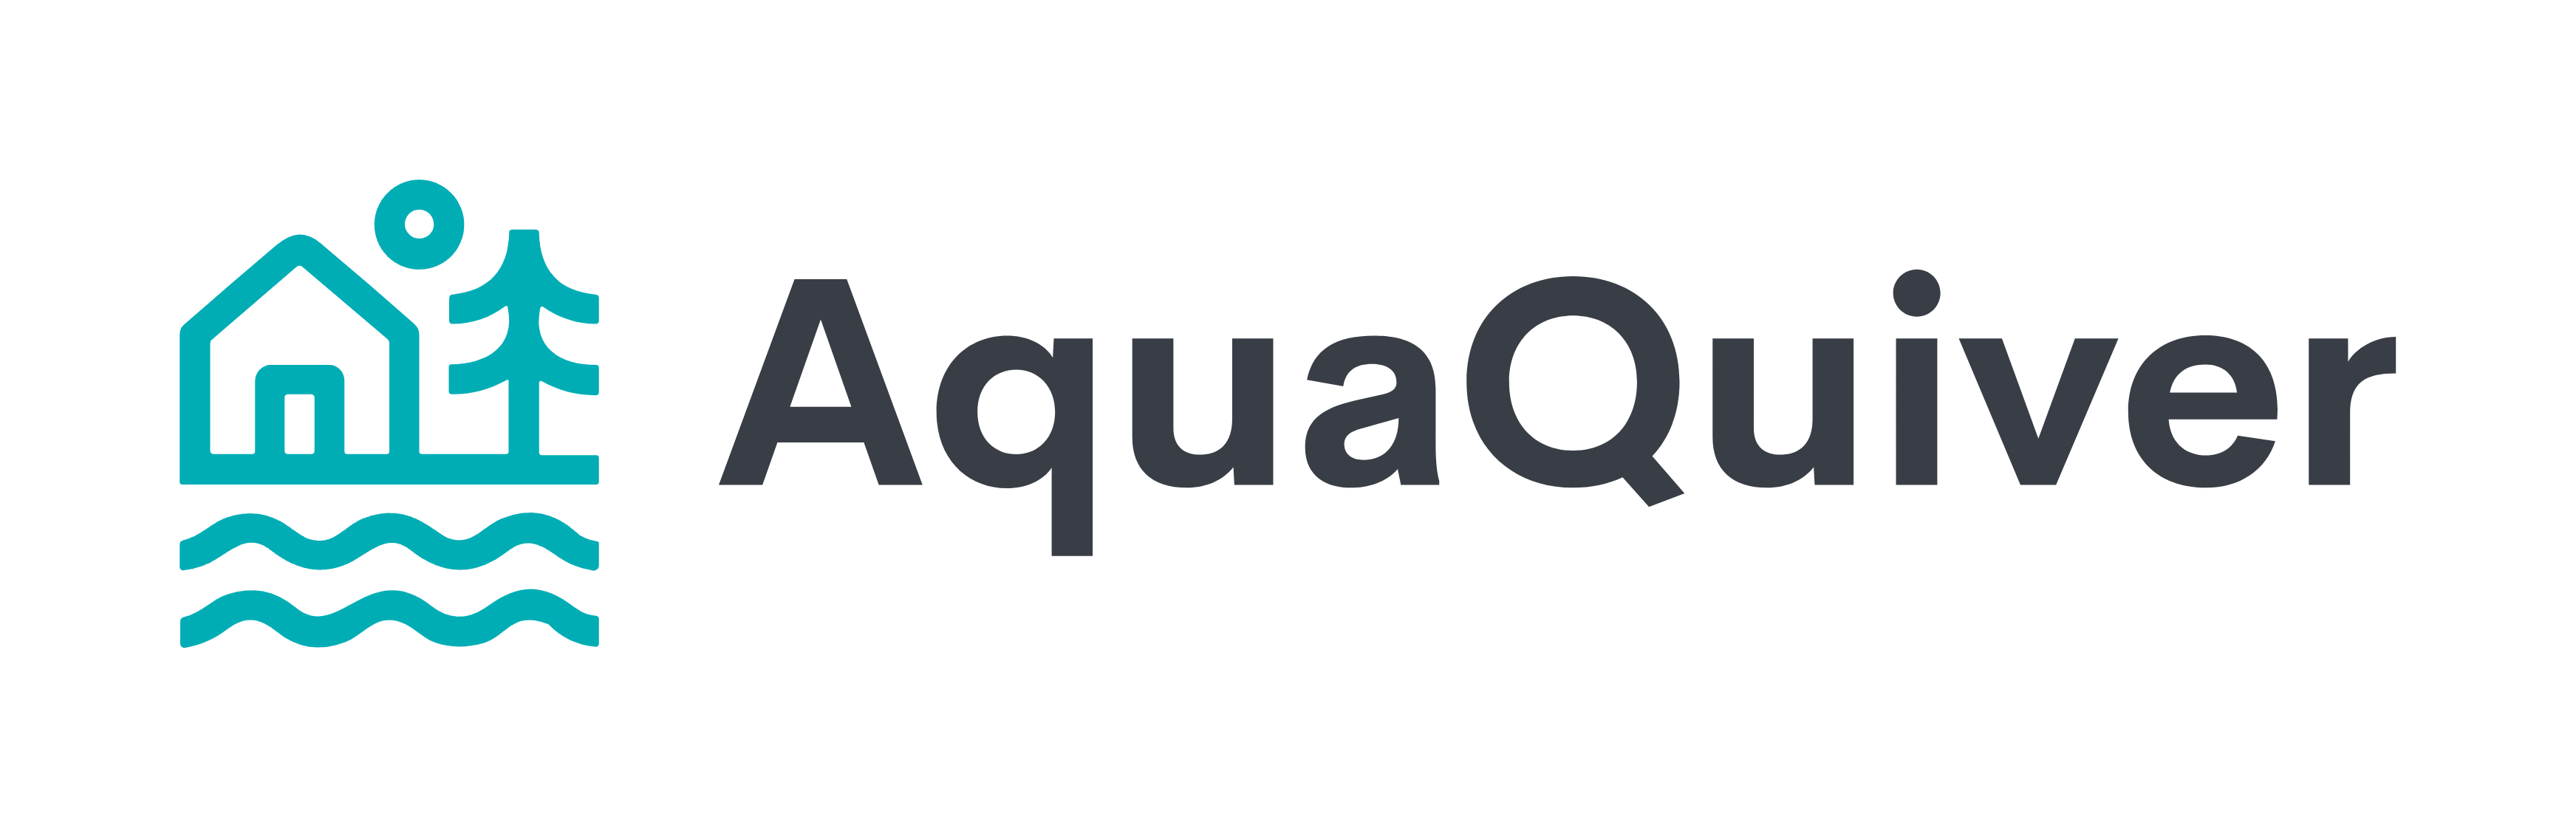
# **Base to Curated: fact_sales_transactions**
</center>

### **Load utility function**

#### The notebook builds upon functions defined in AquaShack_functions.  

In [ ]:
from datafusion import SessionContext
from deltalake import DeltaTable
import pyarrow as pa

ctx = SessionContext()

In [ ]:
%run AquaQuiver_functions

# **Defining settings**
#### Some settings run through the notebook and easy to set once before the job starts.

In [ ]:
destination_lakehouse: str = 'Curated'
fact_name: str = 'Transactions'

# **Defining business requirements**

#### This could also be pure PySpark or Spark SQL, it depends on the skill set of the BI Developer.

In [ ]:
arrow_table = DeltaTable("/lakehouse/default/Tables/sales_Transactions/").to_pyarrow_table()

df = ctx.from_arrow(name='sales_transactions', data=arrow_table)

fact_df = ctx.sql("""
SELECT
    -- Keys
    CAST(to_char(TransactionDate, '%Y%m%d') AS INT)  AS dwid_date,
    CAST(CustomerId AS INT)                        AS dwid_customer,
    CAST(ProductID  AS INT)                        AS dwid_product,

    -- Attributes
    TransactionID,

    -- Measures
    CAST(Quantity AS INT)                          AS m_quantity,
    TotalPrice / Quantity                          AS m_unitprice,
    TotalPrice                                     AS m_totalprice
FROM sales_transactions
""")


# **Writing the fact**

#### Fetch the DataFrame and pass it to our function for writing facts

In [ ]:
batches = fact_df.collect()
transaction_table: pa.Table = pa.Table.from_batches(batches)

load_fact(table=transaction_table, database = destination_lakehouse, delta_table = fact_name)